## ReLU-Diffusion (time-conditioned ReLU-DAE)
This notebook reproduces **Figures 4-5**:

1. Load CelebA.
2. Train a time-conditioned ReLU-DAE (pretrained weights provided).
3. Visualize weights and representations; run sampling.

### Outputs
Plots are saved to `Figs/` when the plotting cells run.


/Users/zhangzekai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


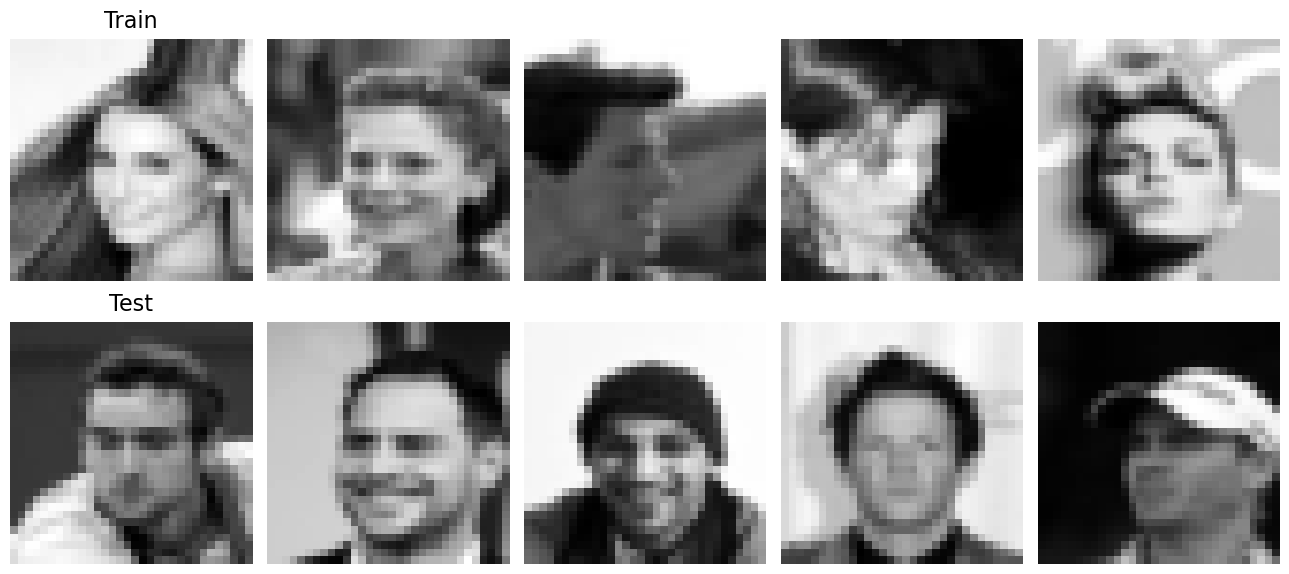

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from datasets import load_dataset

os.makedirs("../Figs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# CelebA (32×32 grayscale), streamed from HuggingFace
N_train, N_test = 100_000, 20
tfm = T.Compose([
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),  # [0,1]
])

ds = load_dataset("eurecom-ds/celeba", split="train", streaming=True)
it = iter(ds)
trainset = torch.stack([tfm(next(it)["image"]) for _ in range(N_train)])
testset  = torch.stack([tfm(next(it)["image"]) for _ in range(N_test)])

# quick sanity check
fig, axes = plt.subplots(2, 5, figsize=(13, 6))
for i in range(5):
    axes[0, i].imshow(trainset[i, 0].numpy(), cmap="gray"); axes[0, i].axis("off")
    axes[1, i].imshow(testset[i, 0].numpy(),  cmap="gray"); axes[1, i].axis("off")
axes[0, 0].set_title("Train", fontsize=16, pad=8)
axes[1, 0].set_title("Test",  fontsize=16, pad=8)
plt.tight_layout()
plt.show()


### ReLU-Diffusion denoiser (time-conditioned ReLU-DAE)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DAECond(nn.Module):
    """A minimal denoiser for VE diffusion in vector space.
    - Encoder-Decoder weight tying
    - Multiplicative time-conditioning on the hidden activations
    - A learnable skip connection (initialized to 0)
    """
    def __init__(self, in_dim=32 * 32, hid=256):
        super().__init__()
        self.encoder = nn.Linear(in_dim, hid, bias=False)
        self.act = nn.ReLU(inplace=True)
        self.skip = nn.Parameter(torch.tensor(0.0))

        # log_sigma -> log_scale (then scale = exp(log_scale) > 0)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hid),
            nn.ReLU(inplace=True),
            nn.Linear(hid, hid),
        )

        nn.init.kaiming_uniform_(self.encoder.weight, a=0.0, mode="fan_in", nonlinearity="relu")
        nn.init.zeros_(self.time_mlp[-1].weight)
        nn.init.zeros_(self.time_mlp[-1].bias)

    def forward(self, x_t: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
        """Predict x0 from noisy x_t.

        Args:
            x_t:       [B, D]
            log_sigma: [B] (or [B,1])
        """
        if log_sigma.dim() == 1:
            log_sigma = log_sigma[:, None]
        h = self.act(self.encoder(x_t))                 # [B, hid]
        h = h * torch.exp(self.time_mlp(log_sigma))     # [B, hid]
        x0_hat = F.linear(h, self.encoder.weight.t())   # [B, D], tied decoder
        return x0_hat + self.skip * x_t

    # TODO: remove this method for simplicity
    @torch.no_grad()
    def rep(self, x_t: torch.Tensor, log_sigma: torch.Tensor) -> torch.Tensor:
        """Return the conditioned hidden representation."""
        # if log_sigma.dim() == 1:
        #     log_sigma = log_sigma[:, None]
        h = self.act(self.encoder(x_t))
        return h


### Train a memorized model (5 samples)


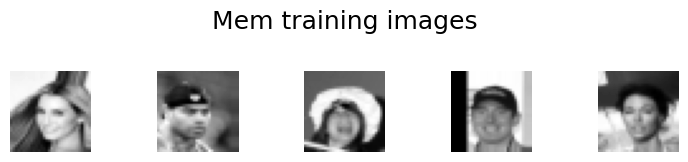

In [3]:
############### Select 5 images for training Mem. model ###################
# Hint: these indices are picked for strong separability (feel free to try others)
idxs = [0, 36, 148, 195, 232]
img_mem  = trainset[idxs] * 2 - 1              # [5,1,32,32] in [-1,1]
flat_mem = img_mem.view(len(idxs), -1)         # [5,1024]

# visualize
plt.figure(figsize=(1.5 * len(idxs), 1.5))
for i in range(len(idxs)):
    ax = plt.subplot(1, len(idxs), i + 1)
    ax.imshow(((img_mem[i, 0] + 1) / 2).numpy(), cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]); ax.axis("off")
plt.suptitle("Mem training images", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

# ###################### Training (uncomment to train) ######################
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(1)
# model_mem = DAECond(in_dim=1024, hid=256).to(device).train()
# opt = torch.optim.RMSprop(model_mem.parameters(), lr=1e-3, weight_decay=1e-2)
# criterion = nn.MSELoss()
# sigma_min, sigma_max = 0.02, 2.0  # VE range

# def sample_sigmas(bsz, device=device):
#     # log-uniform over [sigma_min, sigma_max]
#     u = torch.rand(bsz, device=device)
#     log_s_min = torch.log(torch.tensor(sigma_min, device=device))
#     log_s_max = torch.log(torch.tensor(sigma_max, device=device))
#     log_sigma = log_s_min + u * (log_s_max - log_s_min)
#     return torch.exp(log_sigma)  # [B]

# ds = torch.utils.data.TensorDataset(flat_mem)
# loader = torch.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=True, drop_last=True)

# steps, log_every = 100_000, 10_000
# step = 0
# while step < steps:
#     for (x0,) in loader:
#         x0 = x0.to(device)
#         B = x0.size(0)
#         sigma = sample_sigmas(B)
#         x_t = x0 + sigma[:, None] * torch.randn_like(x0)
#         x0_hat = model_mem(x_t, torch.log(sigma))
#         loss = criterion(x0_hat, x0)
#         opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
#         if step % log_every == 0:
#             print(f"step {step:6d} | loss {loss.item():.4f}")
#         step += 1
#         if step >= steps:
#             break
# torch.save(model_mem.state_dict(), "checkpoints/Diffusion_sample_5.pth")
# print("Saved: checkpoints/Diffusion_sample_5.pth")


### Train a generalized model (20,000 samples)


In [4]:
############### Select N images for training Gen. model ###################
img_gen  = trainset * 2 - 1                 # [N_train,1,32,32] in [-1,1]
flat_gen = img_gen.view(N_train, -1)        # [N_train,1024]

# ###################### Training (uncomment to train) ######################
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(1)
# model_gen = DAECond(in_dim=1024, hid=256).to(device).train()
# opt = torch.optim.Adam(model_gen.parameters(), lr=5e-5, weight_decay=5e-4)
# # opt = torch.optim.RMSprop(model_gen.parameters(), lr=5e-5, weight_decay=5e-4)
# criterion = nn.MSELoss()
# sigma_min, sigma_max = 0.02, 2.0

# def sample_sigmas(bsz, device=device):
#     u = torch.rand(bsz, device=device)
#     log_s_min = torch.log(torch.tensor(sigma_min, device=device))
#     log_s_max = torch.log(torch.tensor(sigma_max, device=device))
#     log_sigma = log_s_min + u * (log_s_max - log_s_min)
#     return torch.exp(log_sigma)

# ds = torch.utils.data.TensorDataset(flat_gen)
# loader = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True, drop_last=True)

# steps, log_every = 200_000, 10_000
# step = 0
# while step < steps:
#     for (x0,) in loader:
#         x0 = x0.to(device)
#         B = x0.size(0)
#         sigma = sample_sigmas(B)
#         x_t = x0 + sigma[:, None] * torch.randn_like(x0)
#         x0_hat = model_gen(x_t, torch.log(sigma))
#         loss = criterion(x0_hat, x0)
#         opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
#         if step % log_every == 0:
#             print(f"step {step:6d} | loss {loss.item():.4f}")
#         step += 1
#         if step >= steps:
#             break
# torch.save(model_gen.state_dict(), "checkpoints/Diffusion_sample_100000.pth")
# print("Saved: checkpoints/Diffusion_sample_100000.pth")

### Load checkpoints


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mem = DAECond(in_dim=1024, hid=256).to(device).eval()
model_gen = DAECond(in_dim=1024, hid=256).to(device).eval()

model_mem.load_state_dict(torch.load("checkpoints/Diffusion_sample_5.pth", map_location=device))
model_gen.load_state_dict(torch.load("checkpoints/Diffusion_sample_100000.pth", map_location=device))

<All keys matched successfully>

### Figure 4: Learned weights (memorized vs generalized)


/var/folders/1h/5vgwqzz531v9hcsgfvmx_fnc0000gn/T/ipykernel_35861/1017067376.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


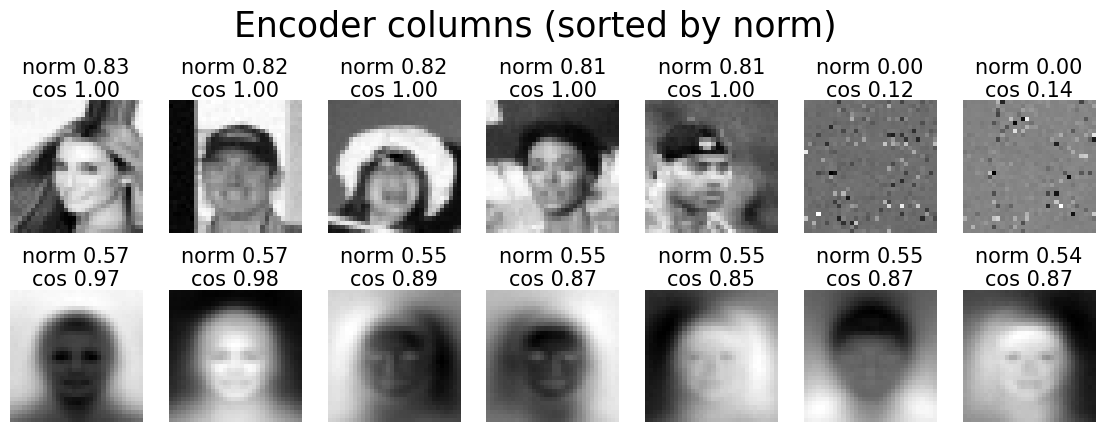

In [6]:
img_norm = flat_gen / torch.linalg.norm(flat_gen, dim=1, keepdim=True).clamp_min(1e-12)

Wm = model_mem.encoder.weight.detach().cpu()  # [H, D]
Wg = model_gen.encoder.weight.detach().cpu()

top_k = min(7, Wm.shape[0])
fig, axes = plt.subplots(2, top_k, figsize=(2.0 * top_k, 4.8), gridspec_kw={"hspace": 0.05})

for r, (W, name) in enumerate([(Wm, "Mem"), (Wg, "Gen")]):
    norms = torch.linalg.norm(W, dim=1)
    idxs = torch.argsort(norms, descending=True)[:top_k]
    for j, idx in enumerate(idxs):
        w = W[idx]
        max_cos = ((w @ img_norm.T) / w.norm().clamp_min(1e-12)).max().item()
        ax = axes[r, j]
        ax.imshow(w.view(32, 32).numpy(), cmap="gray")
        ax.set_title(f"norm {norms[idx]:.2f}\ncos {max_cos:.2f}", fontsize=15, pad=2)
        ax.set_xticks([]); ax.set_yticks([]); ax.axis("off")
    axes[r, 0].set_ylabel(name, fontsize=20, labelpad=10)

plt.suptitle("Encoder columns (sorted by norm)", fontsize=25, y=1.02)
plt.tight_layout()
# plt.savefig("../Figs/celeba_weights_diffusion.png", dpi=200)
plt.show()

### Figure 5: Representations (memorized vs generalized)


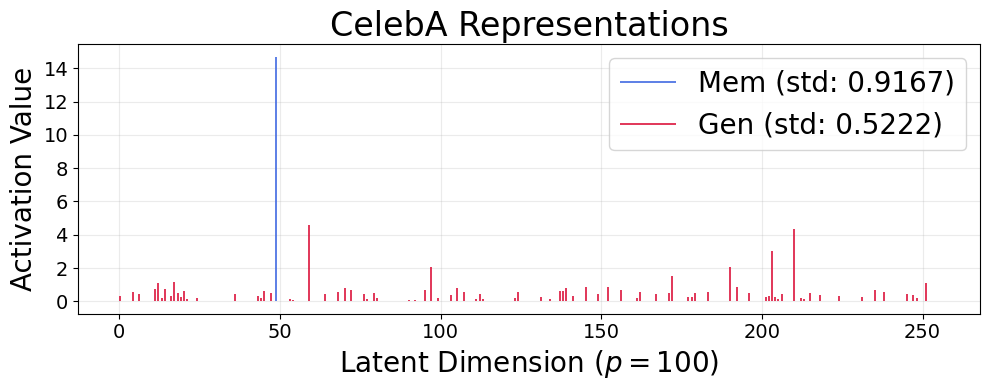

In [ ]:
sigma = 0.2
B = 5
with torch.no_grad():
    x0 = flat_mem[:B].to(device)
    x_t = x0 + sigma * torch.randn_like(x0)
    log_sigma = torch.full((B,), float(np.log(sigma)), device=device)

    rep_mem = model_mem.rep(x_t, log_sigma)[0].detach().cpu().numpy()
    rep_gen = model_gen.rep(x_t, log_sigma)[0].detach().cpu().numpy()

x = np.arange(rep_mem.size)
plt.figure(figsize=(10, 4))
for y, dx, c, name in [(rep_mem, -0.12, "royalblue", "Mem"),
                       (rep_gen, +0.12, "crimson", "Gen")]:
    plt.vlines(x + dx, 0, y, lw=3, color=c, label=f"{name} (std: {y.std():.4f})")

plt.xlabel(r"Latent Dimension ($p=100$)", fontsize=20)
plt.ylabel("Activation Value", fontsize=20)
plt.title("CelebA Representations", fontsize=24)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.legend(fontsize=20, loc="upper right")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


### Sampling (VE)


In [8]:
@torch.no_grad()
def ve_sample_x0(model, n=16, num_steps=60, sigma_min=0.02, sigma_max=2.0, clamp=True, seed=0):
    """VE sampling using an x0-predictor.

    Update:
        score(x,σ) ≈ (x0_hat(x,σ) - x) / σ^2
        x <- x + (σ^2 - σ_next^2) * score + sqrt(σ^2 - σ_next^2) * z
    """
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    sigmas = torch.tensor(np.geomspace(sigma_max, sigma_min, num_steps), device=device, dtype=torch.float32)
    sigmas = torch.cat([sigmas, torch.zeros(1, device=device)])  # convenience

    D = model.encoder.in_features
    x = sigmas[0] * torch.randn(n, D, device=device)

    for i in range(num_steps):
        sigma = sigmas[i]
        sigma_next = sigmas[i + 1]
        log_sigma = torch.full((n,), torch.log(sigma + 1e-12).item(), device=device)

        x0_hat = model(x, log_sigma)
        score = (x0_hat - x) / (sigma * sigma + 1e-12)

        delta = sigma * sigma - sigma_next * sigma_next
        x = x + delta * score
        if sigma_next > 0:
            x = x + torch.sqrt(delta) * torch.randn_like(x)

        if clamp:
            x = x.clamp(-1, 1)

    return x  # treated as x0 at the end

### Sample and compare nearest neighbors


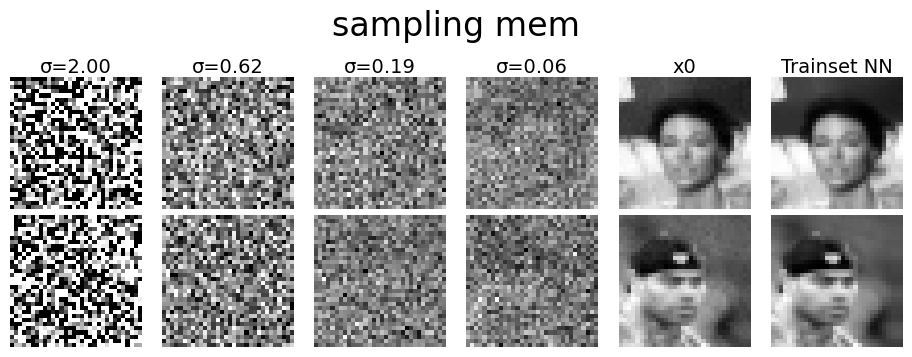

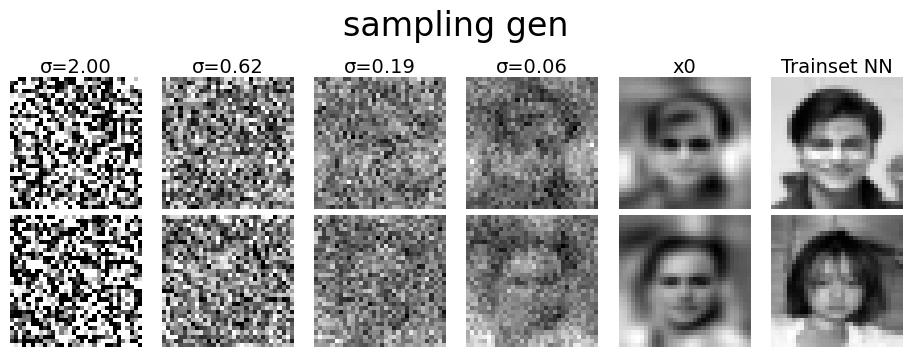

In [13]:
# --- VE sampling trajectory (left->right) + NN on the rightmost ---

@torch.no_grad()
def ve_sample_traj(
    model,
    n=8,
    num_steps=60,
    sigma_min=0.02,
    sigma_max=2.0,
    clamp=True,
    seed=0,
    keep=7,  # number of snapshots shown (incl. initial noise + final x0)
):
    """Return (traj, sigmas_shown), where traj is [n, keep, D]."""
    device = next(model.parameters()).device
    torch.manual_seed(seed)

    sigmas = torch.tensor(np.geomspace(sigma_max, sigma_min, num_steps), device=device, dtype=torch.float32)
    sigmas = torch.cat([sigmas, torch.zeros(1, device=device)])  # length = num_steps + 1

    D = model.encoder.in_features
    x = sigmas[0] * torch.randn(n, D, device=device)

    snap_steps = np.linspace(0, num_steps, keep, dtype=int).tolist()  # in [0..num_steps]
    snap_set = set(snap_steps)

    snaps = []
    if 0 in snap_set:
        snaps.append(x.clone())

    for i in range(num_steps):
        sigma = sigmas[i]
        sigma_next = sigmas[i + 1]
        log_sigma = torch.full((n,), torch.log(sigma + 1e-12).item(), device=device)

        x0_hat = model(x, log_sigma)
        score = (x0_hat - x) / (sigma * sigma + 1e-12)

        delta = sigma * sigma - sigma_next * sigma_next
        x = x + delta * score
        if sigma_next > 0:
            x = x + torch.sqrt(delta) * torch.randn_like(x)

        if clamp:
            x = x.clamp(-1, 1)

        step = i + 1  # x now corresponds to sigma = sigmas[step]
        if step in snap_set:
            snaps.append(x.clone())

    traj = torch.stack(snaps, dim=1)  # [n, keep, D]
    sigmas_shown = sigmas[torch.tensor(snap_steps, device=device)].detach().cpu().numpy()
    return traj.detach().cpu(), sigmas_shown


@torch.no_grad()
def cosine_nn_idx(x: torch.Tensor, bank: torch.Tensor, chunk=4096):
    """Return argmax cosine similarity indices for each row in x against bank."""
    x = x / x.norm(dim=1, keepdim=True).clamp_min(1e-12)
    bank = bank / bank.norm(dim=1, keepdim=True).clamp_min(1e-12)

    best_sim = torch.full((x.size(0),), -1e9, device=x.device)
    best_idx = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

    for s in range(0, bank.size(0), chunk):
        b = bank[s:s+chunk].to(x.device)
        sims = x @ b.t()
        sim, idx = sims.max(dim=1)
        better = sim > best_sim
        best_sim[better] = sim[better]
        best_idx[better] = idx[better] + s

    return best_idx.detach().cpu(), best_sim.detach().cpu()


def _imshow_flat(ax, vec, title=None, H=32, W=32):
    img = vec.view(H, W).cpu().numpy()
    # img = (img + 1.0) / 2.0
    img_disp = (np.clip(img, -1.0, 1.0) + 1.0) / 2.0
    ax.imshow(img_disp, cmap="gray")
    if title is not None:
        ax.set_title(title, fontsize=14, pad=4)
    ax.axis("off")


def show_traj_and_nn(traj, sigmas_shown, bank, title, nn_chunk=2048):
    n, k, D = traj.shape

    x0 = traj[:, -1, :]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    idx, sim = cosine_nn_idx(x0.to(device), bank, chunk=nn_chunk)
    fig, axes = plt.subplots(
        n, k + 1,
        figsize=(1.55 * (k + 1), 1.55 * n),
        gridspec_kw={"wspace": 0.01, "hspace": 0.05}  # tighter gaps
    )
    axes = np.asarray(axes)

    col_titles = []
    for s in sigmas_shown:
        col_titles.append("x0" if s <= 1e-6 else f"σ={s:.2f}")
    col_titles.append("NN")

    for i in range(n):
        for j in range(k):
            _imshow_flat(axes[i, j], traj[i, j], title=(col_titles[j] if i == 0 else None))
        nn_img = bank[idx[i]].view(32, 32)
        _imshow_flat(axes[i, k], nn_img.view(-1), title=("Trainset NN" if i == 0 else None))

    fig.suptitle(title, fontsize=24, y=1.1)

    fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.88, wspace=0.01, hspace=0.06)
    fig.savefig(f"../Figs/celeba_{title.replace(' ', '_')}.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)


# ---- run (Mem + Gen) ----
traj_mem, sig_mem = ve_sample_traj(model_mem, n=2, num_steps=60, seed=1, keep=5)
traj_gen, sig_gen = ve_sample_traj(model_gen, n=2, num_steps=60, seed=5, keep=5)

show_traj_and_nn(traj_mem, sig_mem, flat_gen, "sampling mem")
show_traj_and_nn(traj_gen, sig_gen, flat_gen, "sampling gen")
